# Transfer learning

In [1]:
import tensorflow as tf
from keras.models import Model, Input
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
from shutil import copyfile

In [2]:
# ensure consistency across runs
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [3]:
data_dir = '/kaggle/input/image-types-from-test33/'
data_dir = pathlib.Path(data_dir)

In [4]:
drawings = list(data_dir.glob('drawings/*/*/*.png'))
clipart = list(data_dir.glob('clipart/*/*/*.jpg'))
photo = list(data_dir.glob('photo/*/*/*.jpg'))

In [5]:
print("Number of drawings:", len(drawings))
print("Number of cliparts:", len(clipart))
print("Number of photos:", len(photo))

Number of drawings: 21459
Number of cliparts: 48833
Number of photos: 175327


In [6]:
os.mkdir('images')
os.mkdir('./images/drawings')
os.mkdir('./images/clipart')
os.mkdir('./images/photo')

In [7]:
num = 2000

dr = random.sample(drawings, num)
cl = random.sample(clipart, num)
ph = random.sample(photo, num)

In [8]:
for i in range(num):
    copyfile(dr[i], './images/drawings/'+str(dr[i]).split('/')[-1])
    copyfile(cl[i], './images/clipart/'+str(cl[i]).split('/')[-1])
    copyfile(ph[i], './images/photo/'+str(ph[i]).split('/')[-1])

In [9]:
data_dir = './images'
data_dir = pathlib.Path(data_dir)

In [10]:
print("Number of drawings:", len(list(data_dir.glob('drawings/*.png'))))
print("Number of cliparts:", len(list(data_dir.glob('clipart/*.jpg'))))
print("Number of photos:", len(list(data_dir.glob('photo/*.jpg'))))

Number of drawings: 2000
Number of cliparts: 2000
Number of photos: 2000


In [11]:
#hyperparameters
batch_size = 16
learning_rate = 0.0001
epochs = 50
decay_rate = learning_rate / epochs
IMAGE_SHAPE = (224, 224, 3)
dropout = 0.5

In [12]:
CLASS_NAMES = ['drawings', 'clipart', 'photo']

In [13]:
from keras.applications.mobilenet import preprocess_input
# preprocessing step is the same for MobileNet, MobileNetV2, InceptionV3, InceptionResNetV2, Xception -- mode "tf"
# for ResNet and VGG it is different: the order of channels should be changed -- mode "caffe"


def load_data():
    # 30% validation set 70% training set
    image_generator = ImageDataGenerator(validation_split=0.3, 
                                         preprocessing_function = preprocess_input,
                                         vertical_flip=True,
                                         horizontal_flip=True,
                                         height_shift_range=0.1,
                                         width_shift_range=0.1
                                         )
    # make the training dataset generator
    train_data_gen = image_generator.flow_from_directory(directory=str(data_dir), batch_size=batch_size,
                                                        classes=list(CLASS_NAMES), target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                        shuffle=True, subset="training",
                                                        #class_mode='binary') #binary model
                                                        class_mode='categorical') #categorical model
    # make the validation dataset generator
    test_data_gen = image_generator.flow_from_directory(directory=str(data_dir), batch_size=batch_size, 
                                                        classes=list(CLASS_NAMES), target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                        shuffle=True, subset="validation",
                                                        #class_mode='binary') #binary model
                                                        class_mode='categorical') #categorical model
    return train_data_gen, test_data_gen, CLASS_NAMES

In [14]:
train_generator, validation_generator, class_names = load_data()
print(class_names)
num_classes = len(class_names)

Found 4200 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.
['drawings', 'clipart', 'photo']


In [15]:
# weights for classes (because the dataset is imbalanced)

counter = Counter(train_generator.classes)

max_val = float(max(counter.values()))
class_weights = {class_id: max_val / num_images for class_id, num_images in counter.items()}
class_weights

{0: 1.0, 1: 1.0, 2: 1.0}

In [16]:
from keras.applications import MobileNet, MobileNetV2, InceptionV3, InceptionResNetV2, Xception

base_model = MobileNetV2( # !!! change model
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=IMAGE_SHAPE,
    include_top=False
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = Input(shape=IMAGE_SHAPE)
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
#x = Dropout(dropout)(x)  
#x = Dense(500)(x)
#x = Dropout(dropout)(x)  
#x = Dense(200)(x)
x = Dropout(dropout)(x)
x = Dense(100)(x)
x = Dropout(dropout)(x)

#binary model
#outputs = Dense(1, activation='sigmoid')(x)
#categorical model
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               128100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
________________________________________________________________

In [17]:
for layer in base_model.layers:
    layer.trainable = False

In [18]:
import tensorflow.keras.backend as K
from tensorflow.keras.losses import CategoricalCrossentropy


class WeightedCategoricalCrossentropy(CategoricalCrossentropy):
    
    def __init__(self, cost_mat, name='weighted_categorical_crossentropy', **kwargs):
        assert cost_mat.ndim == 2
        assert cost_mat.shape[0] == cost_mat.shape[1]
        
        super().__init__(name=name, **kwargs)
        self.cost_mat = K.cast_to_floatx(cost_mat)
    
    def __call__(self, y_true, y_pred, sample_weight=None):
        assert sample_weight is None, "should only be derived from the cost matrix"
      
        return super().__call__(
            y_true=y_true,
            y_pred=y_pred,
            sample_weight=get_sample_weights(y_true, y_pred, self.cost_mat),
        )


def get_sample_weights(y_true, y_pred, cost_m):
    num_classes = len(cost_m)

    y_pred.shape.assert_has_rank(2)
    y_pred.shape[1:].assert_is_compatible_with(num_classes)
    y_pred.shape.assert_is_compatible_with(y_true.shape)

    y_pred = K.one_hot(K.argmax(y_pred), num_classes)

    y_true_nk1 = K.expand_dims(y_true, 2)
    y_pred_n1k = K.expand_dims(y_pred, 1)
    cost_m_1kk = K.expand_dims(cost_m, 0)

    sample_weights_nkk = cost_m_1kk * y_true_nk1 * y_pred_n1k
    sample_weights_n = K.sum(sample_weights_nkk, axis=[1, 2])

    return sample_weights_n

In [19]:
from tensorflow.keras.metrics import CategoricalAccuracy

        
class WeightedCategoricalAccuracy(CategoricalAccuracy):

    def __init__(self, cost_mat, name='weighted_categorical_accuracy', **kwargs):
        assert cost_mat.ndim == 2
        assert cost_mat.shape[0] == cost_mat.shape[1]
        
        super().__init__(name=name, **kwargs)
        self.cost_mat = K.cast_to_floatx(cost_mat)
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        assert sample_weight is None, "should only be derived from the cost matrix"
    
        return super().update_state(
            y_true=y_true,
            y_pred=y_pred,
            sample_weight=get_sample_weights(y_true, y_pred, self.cost_mat),
        )

In [20]:
cost_matrix  = tf.constant([
       [0.5, 20., 2.],
       [2., 0.5, 2.],
       [2., 1., 0.5]])

In [21]:
opt = Adam(lr=learning_rate)

#binary model
#model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
#categorical model
model.compile(loss=WeightedCategoricalCrossentropy(cost_matrix), optimizer=opt, metrics=[WeightedCategoricalAccuracy(cost_matrix),"accuracy"])

# count number of steps per epoch
training_steps_per_epoch = np.ceil(train_generator.samples / batch_size)
validation_steps_per_epoch = np.ceil(validation_generator.samples / batch_size)


checkpoint = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1, save_best_only=True, mode='auto', period=1)

# train using the generators
history = model.fit(train_generator, steps_per_epoch=training_steps_per_epoch,
                        validation_data=validation_generator, validation_steps=validation_steps_per_epoch,
                        epochs=epochs, shuffle=True, workers=4, callbacks=[checkpoint])

Epoch 1/50
263/263 [==============================] - ETA: 0s - loss: 3.9938 - weighted_categorical_accuracy: 0.1813 - accuracy: 0.5467
Epoch 00001: loss improved from inf to 3.99377, saving model to best_model.hdf5
263/263 [==============================] - 91s 347ms/step - loss: 3.9938 - weighted_categorical_accuracy: 0.1813 - accuracy: 0.5467 - val_loss: 0.6873 - val_weighted_categorical_accuracy: 0.5263 - val_accuracy: 0.7828
Epoch 2/50
263/263 [==============================] - ETA: 0s - loss: 1.6751 - weighted_categorical_accuracy: 0.3625 - accuracy: 0.6995
Epoch 00002: loss improved from 3.99377 to 1.67513, saving model to best_model.hdf5
263/263 [==============================] - 92s 351ms/step - loss: 1.6751 - weighted_categorical_accuracy: 0.3625 - accuracy: 0.6995 - val_loss: 0.4247 - val_weighted_categorical_accuracy: 0.6583 - val_accuracy: 0.8478
Epoch 3/50
262/263 [============================>.] - ETA: 0s - loss: 1.2688 - weighted_categorical_accuracy: 0.4276 - accuracy:

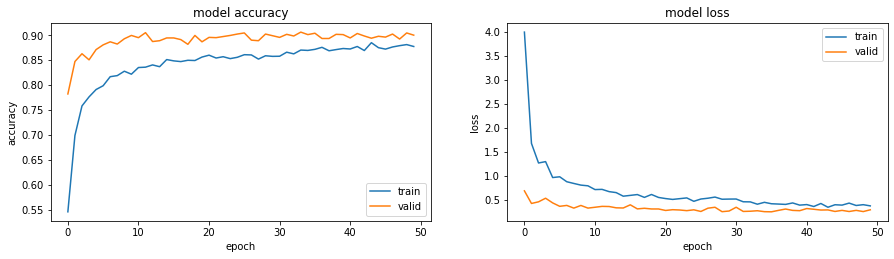

In [22]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

# Validation

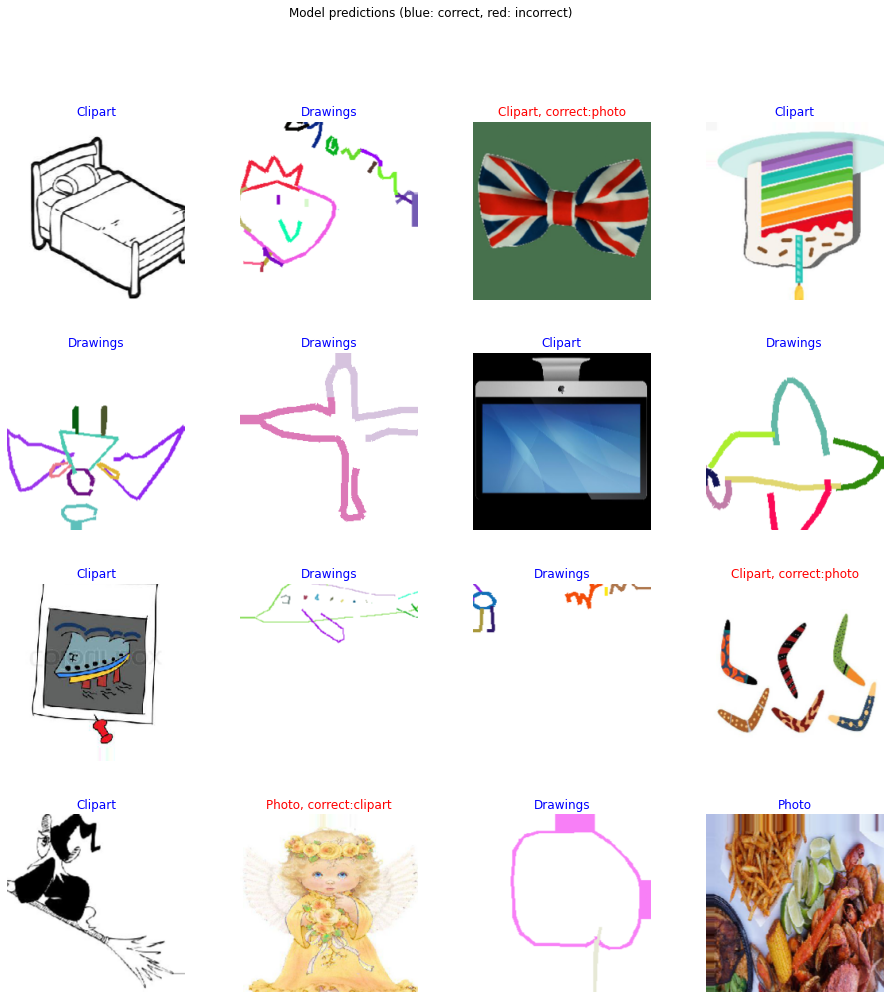

In [23]:
# get a random batch of images
image_batch, label_batch = next(iter(validation_generator))
# turn the original labels into human-readable text
label_batch = [class_names[np.argmax(label_batch[i])] for i in range(batch_size)]
# predict the images on the model
predicted_class_names = model.predict(image_batch)
predicted_ids = [np.argmax(predicted_class_names[i]) for i in range(batch_size)]
# turn the predicted vectors to human readable labels
predicted_class_names = np.array([class_names[id] for id in predicted_ids])
# some nice plotting
plt.figure(figsize=(16,16))
for n in range(16):
    plt.subplot(4,4,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow((image_batch[n]+1)/2) # reverse preprocess_input for mode "tf"
    if predicted_class_names[n] == label_batch[n]:
        color = "blue"
        title = predicted_class_names[n].title()
    else:
        color = "red"
        title = f"{predicted_class_names[n].title()}, correct:{label_batch[n]}"
    plt.title(title, color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")
plt.show()

In [24]:
model.save('model_20_epochs.h5')

In [25]:
from tensorflow.keras.models import load_model
model = load_model("./best_model.hdf5",compile=False) 

In [26]:
model.save('model_20_epochs_best.h5')

# Test set

In [27]:
#from tensorflow.keras.models import load_model
#model = load_model('model_1_epochs_2807.h5')

Upload model from gdrive

In [28]:
#conda install gdown

In [29]:
#import gdown
#url = 'https://drive.google.com/uc?id=18sop_jBSRoP5SOUFA8EhUdl96TIvRQv8' # 1xyqrQlOxTYvQ6jq7DMskXn06qJmzX9r_'
#output = 'model_10_epochs.h5'

#gdown.download(url, output, quiet=False)

In [30]:
#from tensorflow.keras.models import load_model
#model = load_model('./model_10_epochs.h5')

In [31]:
test_dir = '../input/image-types-from-test33/test/test'
test_dir = pathlib.Path(test_dir)

# count how many images are there
print("Number of png images:", len(list(test_dir.glob('*/*.png'))))
print("Number of jpg images:", len(list(test_dir.glob('*/*.jpg'))))
print("Number of drawings:", len(list(test_dir.glob('drawings/*.png'))))
print("Number of cliparts:", len(list(test_dir.glob('clipart/*.png'))))
print("Number of photos:", len(list(test_dir.glob('photo/*.png'))))


Number of png images: 300
Number of jpg images: 0
Number of drawings: 80
Number of cliparts: 114
Number of photos: 106


In [32]:
# get all classes for this dataset
#CLASS_NAMES = np.array([item.name for item in test_dir.glob('*') if item.name != '.ipynb_checkpoints'])
test_batch_size = 300

image_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
test_generator = image_generator.flow_from_directory(directory=str(test_dir), batch_size=test_batch_size,
                                                    classes=list(class_names), target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                    shuffle=None,
                                                    #class_mode='binary') #binary model
                                                    class_mode='categorical') #categorical model

Found 300 images belonging to 3 classes.


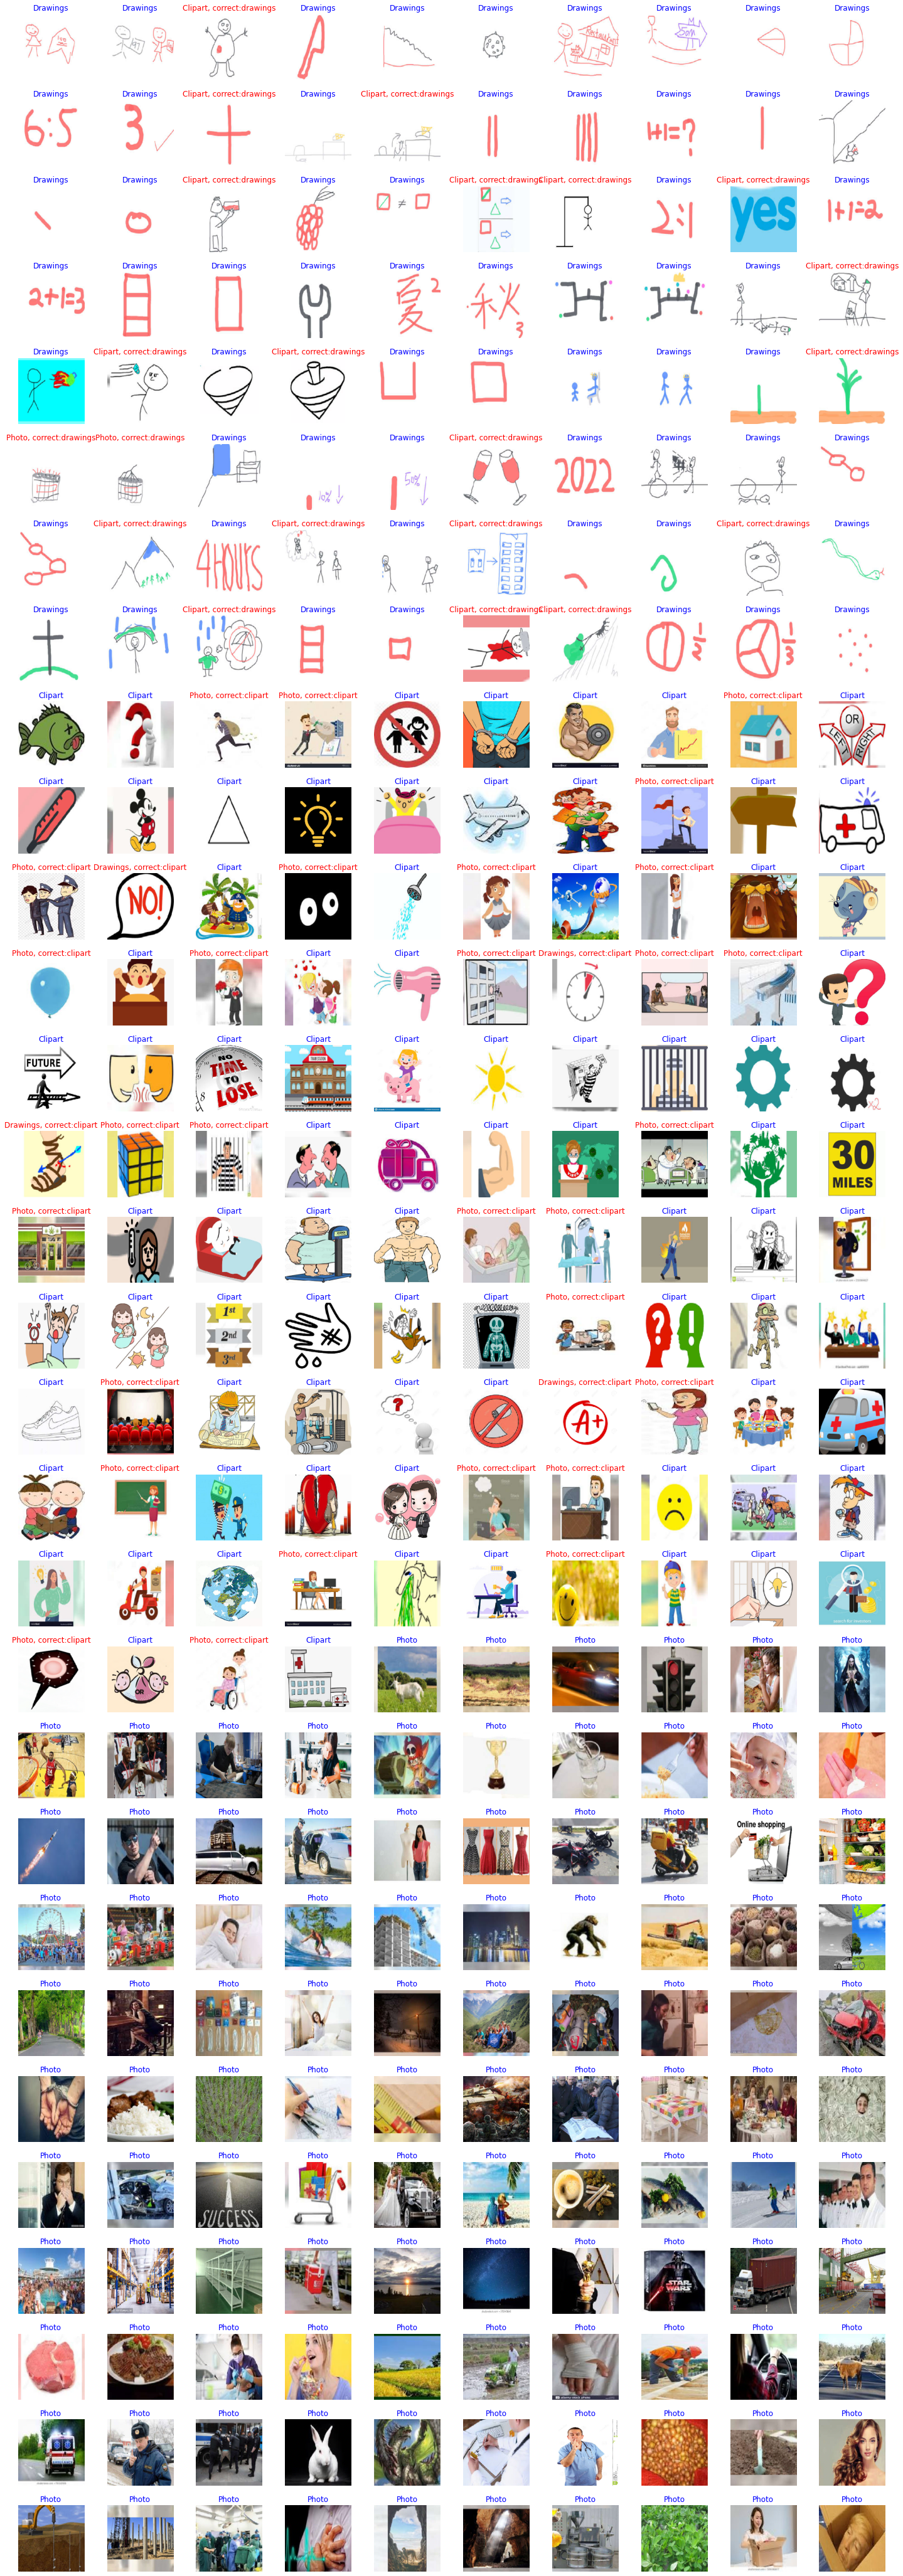

In [33]:
# get a random batch of images
image_batch, label_batch = next(iter(test_generator))
# turn the original labels into human-readable text
label_batch = [class_names[np.argmax(label_batch[i])] for i in range(test_batch_size)]
# predict the images on the model
predicted_class_names = model.predict(image_batch)
predicted_ids = [np.argmax(predicted_class_names[i]) for i in range(test_batch_size)]
# turn the predicted vectors to human readable labels
predicted_class_names = np.array([class_names[id] for id in predicted_ids])
# some nice plotting
plt.figure(figsize=(25,75))
for n in range(300):
    plt.subplot(30,10,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow((image_batch[n]+1)/2) # reverse preprocess_input for mode "tf"
    if predicted_class_names[n] == label_batch[n]:
        color = "blue"
        title = predicted_class_names[n].title()
    else:
        color = "red"
        title = f"{predicted_class_names[n].title()}, correct:{label_batch[n]}"
    plt.title(title, color=color)
    plt.axis('off')
#_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")
plt.savefig('result.png')
plt.show()

In [34]:
import pandas as pd
import numpy as np

In [35]:
res = pd.DataFrame(model.predict(image_batch))
res.columns = ['drawings','clipart','photo']
res['file']=test_generator.filenames
res['true']=label_batch
res['pred']=predicted_class_names
res

drawings   clipart     photo                file      true      pred
0    7.920670e-01  0.196252  0.011681  drawings/12652.png  drawings  drawings
1    7.228716e-01  0.259309  0.017820  drawings/12653.png  drawings  drawings
2    1.896616e-01  0.760215  0.050123  drawings/13694.png  drawings   clipart
3    9.975694e-01  0.001913  0.000518  drawings/13695.png  drawings  drawings
4    9.986714e-01  0.001208  0.000121  drawings/13916.png  drawings  drawings
..            ...       ...       ...                 ...       ...       ...
295  3.980510e-06  0.116573  0.883423        photo/95.png     photo     photo
296  6.738048e-10  0.038763  0.961237        photo/96.png     photo     photo
297  2.008169e-04  0.195025  0.804775        photo/97.png     photo     photo
298  1.176147e-07  0.033269  0.966731        photo/98.png     photo     photo
299  3.945911e-10  0.016532  0.983468        photo/99.png     photo     photo

[300 rows x 6 columns]

In [36]:
res.to_csv('results.csv',sep='\t',index=None)

In [37]:
from sklearn.metrics import confusion_matrix

#test_steps_per_epoch = np.ceil(test_generator.samples / test_batch_size)
#evaluation = model.evaluate_generator(test_generator, steps=test_steps_per_epoch, verbose=1)
#print("Test loss:", evaluation[0])
#print("Test Accuracy:", evaluation[1])

print(confusion_matrix(res.true, res.pred, labels=["drawings", "clipart", "photo"]))
print(confusion_matrix(res.true, res.pred, labels=["drawings", "clipart", "photo"], normalize='true'))
print(np.sum(res.true==res.pred)/len(res.true))

[[ 59  19   2]
 [  4  81  29]
 [  0   0 106]]
[[0.7375     0.2375     0.025     ]
 [0.03508772 0.71052632 0.25438596]
 [0.         0.         1.        ]]
0.82
